<a href="https://colab.research.google.com/github/chenchongsong/udacity-cs344-colab/blob/main/notebook/udacity_cs344_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Homework 1 for Udacity CS344 Course, Intro to Parallel Programming
# clone the code repo,
!git clone https://github.com/chenchongsong/udacity-cs344-colab
!pip install git+git://github.com/depctg/nvcc4jupyter.git

# load cuda plugin
%config NVCCPluginV2.static_dir = True
%config NVCCPluginV2.relative_dir = "udacity-cs344-colab/src/HW1"
%load_ext nvcc_plugin

# change to work directory, generate makefiles
!mkdir udacity-cs344-colab/build
%cd udacity-cs344-colab/build
!cmake ../src

In [19]:
%%cuda --name student_func.cu

// Homework 1
// Color to Greyscale Conversion

//A common way to represent color images is known as RGBA - the color
//is specified by how much Red, Grean and Blue is in it.
//The 'A' stands for Alpha and is used for transparency, it will be
//ignored in this homework.

//Each channel Red, Blue, Green and Alpha is represented by one byte.
//Since we are using one byte for each color there are 256 different
//possible values for each color.  This means we use 4 bytes per pixel.

//Greyscale images are represented by a single intensity value per pixel
//which is one byte in size.

//To convert an image from color to grayscale one simple method is to
//set the intensity to the average of the RGB channels.  But we will
//use a more sophisticated method that takes into account how the eye
//perceives color and weights the channels unequally.

//The eye responds most strongly to green followed by red and then blue.
//The NTSC (National Television System Committee) recommends the following
//formula for color to greyscale conversion:

//I = .299f * R + .587f * G + .114f * B

//Notice the trailing f's on the numbers which indicate that they are
//single precision floating point constants and not double precision
//constants.

//You should fill in the kernel as well as set the block and grid sizes
//so that the entire image is processed.

#include "utils.h"

const int BLOCK_SIZE = 32;

__global__
void rgba_to_greyscale(const uchar4* const rgbaImage,
                       unsigned char* const greyImage,
                       int numRows, int numCols)
{
  //Fill in the kernel to convert from color to greyscale
  //the mapping from components of a uchar4 to RGBA is:
  // .x -> R ; .y -> G ; .z -> B ; .w -> A
  //
  //The output (greyImage) at each pixel should be the result of
  //applying the formula: output = .299f * R + .587f * G + .114f * B;
  //Note: We will be ignoring the alpha channel for this conversion

  //First create a mapping from the 2D block and grid locations
  //to an absolute 2D location in the image, then use that to
  //calculate a 1D offset
  int row = blockIdx.x * blockDim.x + threadIdx.x;
  int col = blockIdx.y * blockDim.y + threadIdx.y;
  if (row >= numRows || col >= numCols) return;
  int id = row * numCols + col;
  const uchar4 rgba = rgbaImage[id];
  greyImage[id] = (unsigned char)(.299f * rgba.x + .587f * rgba.y + .114f * rgba.z);
}

void your_rgba_to_greyscale(const uchar4 * const h_rgbaImage, uchar4 * const d_rgbaImage,
                            unsigned char* const d_greyImage, size_t numRows, size_t numCols)
{
  //You must fill in the correct sizes for the blockSize and gridSize
  //currently only one block with one thread is being launched
  const dim3 blockSize(BLOCK_SIZE, BLOCK_SIZE, 1);
  const dim3 gridSize((numRows + BLOCK_SIZE - 1) / BLOCK_SIZE, (numCols + BLOCK_SIZE - 1) / BLOCK_SIZE, 1);
  rgba_to_greyscale<<<gridSize, blockSize>>>(d_rgbaImage, d_greyImage, numRows, numCols);

  cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

}

'File written in /content/udacity-cs344-colab/src/HW1/student_func.cu'

In [20]:
# make the cuda project
!make HW1
print("\n====== RESULT OF HW1 =======\n")
!bin/HW1 ../src/HW1/cinque_terre.gold

[ 20%] Building NVCC (Device) object HW1/CMakeFiles/HW1.dir/HW1_generated_student_func.cu.o
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
[ 40%] Linking CXX executable ../bin/HW1
[100%] Built target HW1

====== RESULT OF HW1 =======

Your code ran in: 0.141056 msecs.
PASS


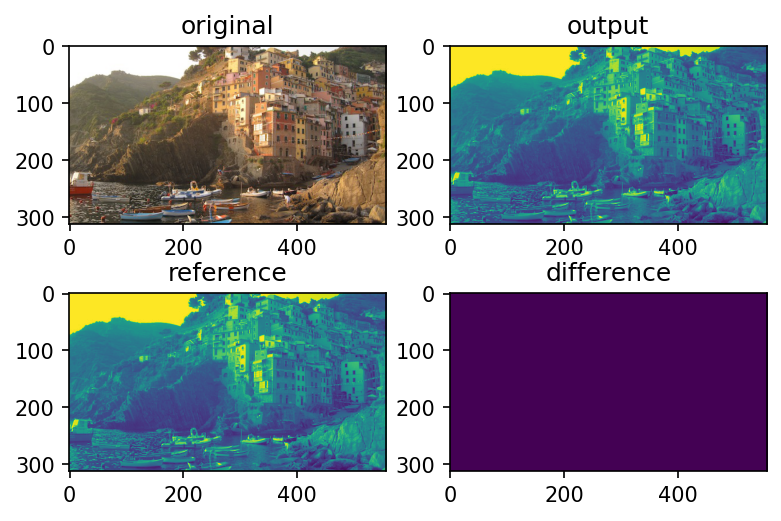

In [21]:
# plot output images
import matplotlib.pyplot as plt
_,ax = plt.subplots(2,2, dpi=150)

ax[0][0].imshow(plt.imread("../src/HW1/cinque_terre_small.jpg"))
ax[0][0].set_title("original")
ax[0][0].grid(False)

ax[0][1].imshow(plt.imread("HW1_output.png"))
ax[0][1].set_title("output")
ax[0][1].grid(False)

ax[1][0].imshow(plt.imread("HW1_reference.png"))
ax[1][0].set_title("reference")
ax[1][0].grid(False)

ax[1][1].imshow(plt.imread("HW1_differenceImage.png"))
ax[1][1].set_title("difference")
ax[1][1].grid(False)

plt.show()